[link](https://www.kaggle.com/budincsevity/szeged-weather)

In [1]:
# импорт библиотек
from typing import Sequence, Union

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor

# версии библиотек
print("Версии библиотек:")
import pkg_resources
import platform

print(f"python=={platform.python_version()}")

# list packages to be checked
root_packages = [
    'pandas', 'numpy', 'matplotlib', 'plotly', 'scikit-learn'
]
# print versions, but check if package is imported first
for m in pkg_resources.working_set:
    if m.project_name.lower() in root_packages:
        print(f"{m.project_name}=={m.version}")

Версии библиотек:
python==3.9.7
plotly==5.2.1
pandas==1.3.2
scikit-learn==1.0.2
numpy==1.21.5
matplotlib==3.5.1


Константы

In [2]:
# pandas
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.mode.chained_assignment = None

# plotly
pio.templates.default = "plotly_dark"  # plotly_dark seaborn
pio.renderers.default = "svg"  # svg notebook_connected plotly_mimetype

# sklearn
rng = np.random.RandomState(0)

In [3]:
df = pd.read_csv('datasets/weather_in_szeged/weatherHistory.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96453 non-null  object 
 1   Summary                   96453 non-null  object 
 2   Precip Type               95936 non-null  object 
 3   Temperature (C)           96453 non-null  float64
 4   Apparent Temperature (C)  96453 non-null  float64
 5   Humidity                  96453 non-null  float64
 6   Wind Speed (km/h)         96453 non-null  float64
 7   Wind Bearing (degrees)    96453 non-null  float64
 8   Visibility (km)           96453 non-null  float64
 9   Loud Cover                96453 non-null  float64
 10  Pressure (millibars)      96453 non-null  float64
 11  Daily Summary             96453 non-null  object 
dtypes: float64(8), object(4)
memory usage: 8.8+ MB


In [4]:
def pythonic_names(df: pd.DataFrame) -> pd.DataFrame:
    res = {}
    for col in df.columns:
        s = col.strip().lower().replace(' ', '_')
        res[col] = s

    return df.rename(columns=res)


df = pythonic_names(df)

display(df.columns)

Index(['formatted_date', 'summary', 'precip_type', 'temperature_(c)',
       'apparent_temperature_(c)', 'humidity', 'wind_speed_(km/h)',
       'wind_bearing_(degrees)', 'visibility_(km)', 'loud_cover',
       'pressure_(millibars)', 'daily_summary'],
      dtype='object')

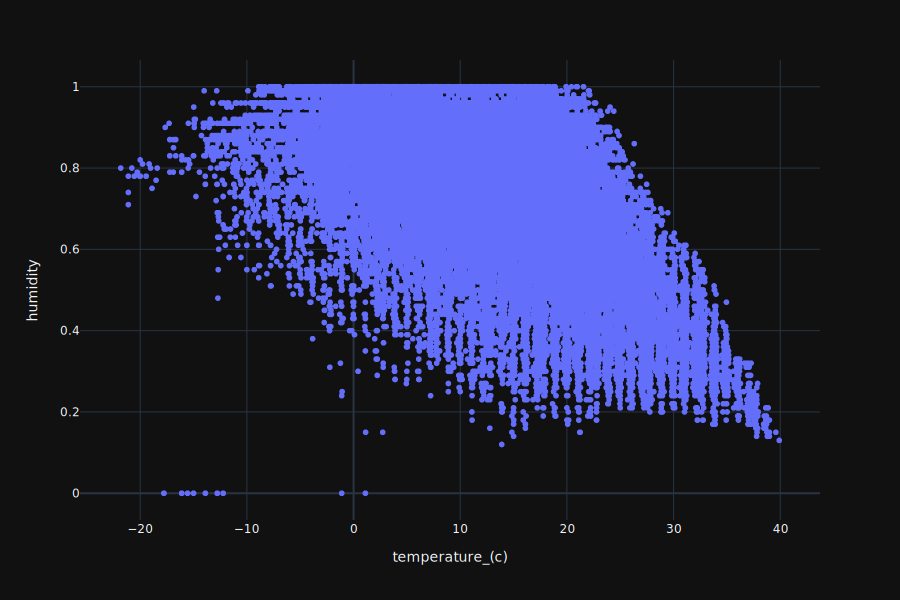

In [5]:
px.scatter(df, x='temperature_(c)', y='humidity', width=900, height=600)

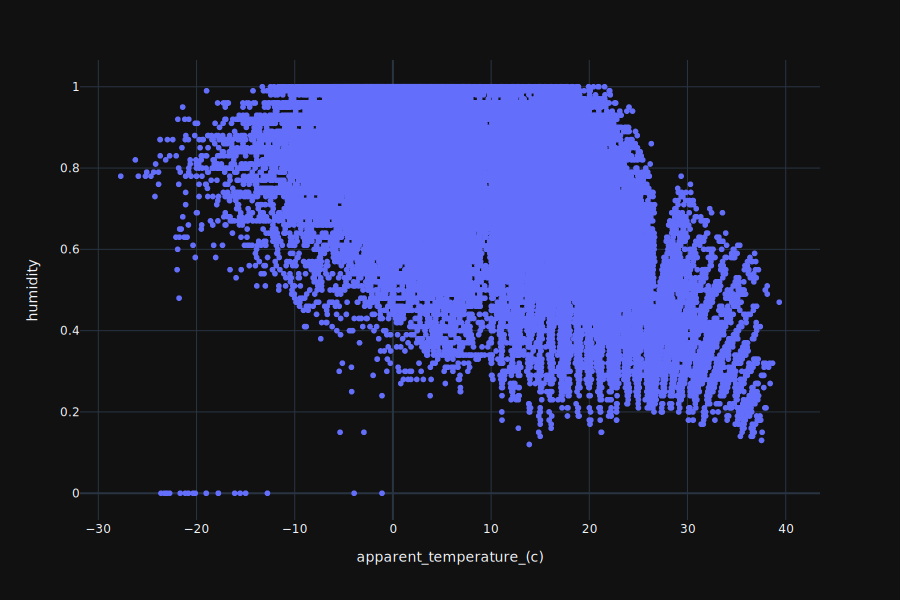

In [6]:
px.scatter(df, x='apparent_temperature_(c)', y='humidity', width=900, height=600)

# EDA


## precip_type

In [7]:
print(df['precip_type'].value_counts())

rain    85224
snow    10712
Name: precip_type, dtype: int64


In [8]:
train, test = train_test_split(df, test_size=0.3, random_state=rng)

In [9]:
features = ['temperature_(c)', 'wind_speed_(km/h)', 'wind_bearing_(degrees)', 'precip_type']
features_scale = ['temperature_(c)', 'wind_speed_(km/h)', 'wind_bearing_(degrees)', ]
features_encode = ['precip_type']

target = ['humidity']

x_train = train[features]
x_test = test[features]
y_train = train[target]
y_test = test[target]

# Выбор модели

In [10]:
def ordinal_encoder(train, test, columns):
    encoder = OrdinalEncoder(dtype=np.uint8)
    encoder.fit(pd.concat([train[columns], test[columns]]))

    train[columns] = pd.DataFrame(encoder.transform(train[columns]), columns=train[columns].columns)
    test[columns] = pd.DataFrame(encoder.transform(test[columns]), columns=test[columns].columns)

    # print(df_train_preprocess_oe.columns)
    # display(df_train_preprocess_oe.head(10))
    return train, test


def standard_scaler(train, test, columns):
    scaler = StandardScaler()
    scaler.fit(train[columns])

    train[columns] = scaler.transform(train[columns])
    test[columns] = scaler.transform(test[columns])

    # display(test.head(10))
    return train, test


def simple_imputer(train, test, columns: list, strategy='mean', fill_value=None, missing_indicator=False):
    # добавляем признак с инфо о пропущенных значениях
    if missing_indicator:
        for col in columns:
            if train[col].isna().sum() > 0 or test[col].isna().sum() > 0:
                train[f'{col}_isna'] = train[col].isna()
                test[f'{col}_isna'] = test[col].isna()

    imputer = SimpleImputer(missing_values=np.nan, strategy=strategy, fill_value=fill_value)
    imputer.fit(train[columns])

    train[columns] = imputer.transform(train[columns])
    test[columns] = imputer.transform(test[columns])

    return train, test


class SimpleImputerMy(BaseEstimator, TransformerMixin):
    def __init__(
        self, columns: Union[list, str], strategy: str = 'mean', fill_value=None, missing_indicator=False
        ) -> None:
        if type(columns) == list:
            self.columns = columns
        elif type(columns) == str:
            self.columns = [columns]
        else:
            raise TypeError('Wrong type of parameter "columns"')

        self.missing_indicator = missing_indicator
        self.fill_value = fill_value
        self.strategy = strategy
        self.imputer = SimpleImputer(missing_values=np.nan, strategy=self.strategy, fill_value=self.fill_value)

    def fit(self, x: pd.DataFrame, y: pd.DataFrame = None) -> 'SimpleImputerMy':
        self.imputer.fit(x[self.columns])
        return self

    def transform(self, x: pd.DataFrame, y: pd.DataFrame = None) -> pd.DataFrame:
        x[self.columns] = self.imputer.transform(x[self.columns])

        # добавляем признак с инфо о пропущенных значениях
        for col in self.columns:
            if self.missing_indicator:
                x[f'{col}_isna'] = x[col].isna()

        return x


class OrdinalEncoderMy:
    def __init__(self, columns: list):
        self.encoder = OrdinalEncoder(dtype=np.float64)
        self.columns = columns

    def fit(self, x: pd.DataFrame, y: pd.DataFrame = None) -> 'OrdinalEncoderMy':
        self.encoder.fit(x[self.columns])
        return self

    def transform(self, x: pd.DataFrame, y: pd.DataFrame = None) -> pd.DataFrame:
        display(x.head(20))

        x[f'{self.columns}_enc'] = pd.DataFrame(
            self.encoder.transform(x[self.columns]), columns=x[self.columns].columns
        )
        display(x.head(20))
        return x


class OneHotEncoderMy(BaseEstimator, TransformerMixin):
    def __init__(self, columns: Union[list, str]) -> None:
        if type(columns) == list:
            self.columns = columns
        elif type(columns) == str:
            self.columns = [columns]
        else:
            raise TypeError('Wrong type of parameter "columns"')

        self.encoders = {}
        for col in self.columns:
            self.encoders[col] = OneHotEncoder(sparse=False, dtype=np.uint8, handle_unknown='ignore')

    def fit(self, x: pd.DataFrame, y: pd.DataFrame = None) -> 'OneHotEncoderMy':
        for col in self.columns:
            self.encoders[col].fit(x[col].to_numpy().reshape(-1, 1))
        return self

    def transform(self, x: pd.DataFrame, y: pd.DataFrame = None) -> pd.DataFrame:
        for col in self.columns:
            feature_names = [f"{col}{x[2:]}" for x in self.encoders[col].get_feature_names_out()]

            x_transformed = self.encoders[col].transform(x[col].to_numpy().reshape(-1, 1))
            x_transformed_df = pd.DataFrame(x_transformed, columns=feature_names, index=x.index)
            x = pd.concat([x, x_transformed_df], axis=1).drop(columns=[col])

        # display(x)

        return x

## DecisionTreeRegressor

In [11]:
# x_train, x_test = simple_imputer(x_train, x_test, ['precip_type'], strategy='most_frequent')

pipe_pre = Pipeline(
    [
        ('impute', SimpleImputerMy(['precip_type'], strategy='most_frequent')),
        ('encode', OneHotEncoderMy('precip_type')),
    ]
)

pipe = Pipeline(
    [
        ('pre', pipe_pre),
        ('model', DecisionTreeRegressor(random_state=1)),
    ]
)

# print(pipe.named_steps['preprocessor'].fit_transform(x_train))

pipe.fit(x_train.copy(), y_train.copy())
print(pipe.score(x_test, y_test))

# model = DecisionTreeRegressor(random_state=rng)
# model.fit(x_train, y_train)

0.12992051935518556


## RandomForestRegressor

In [ ]:
pipe_pre1 = Pipeline(
    [
        ('impute', SimpleImputerMy(['precip_type'], strategy='most_frequent')),
        ('encode', OneHotEncoderMy('precip_type')),
    ]
)

pipe = Pipeline(
    [
        ('pre', pipe_pre1),
        ('model', RandomForestRegressor(random_state=1, n_jobs=-1)),
    ]
)

search_params = {
    'model__n_estimators' : np.arange(2, 1000, 50),
}

search = RandomizedSearchCV(pipe, param_distributions=search_params, random_state=1, verbose=True)

search.fit(x_train.copy(), np.ravel(y_train.copy()))
print(search.best_score_)

# pipe.fit(x_train.copy(), y_train.copy())
# print(pipe.score(x_test.copy(), y_test.copy()))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
